In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow.keras.layers import Dense, Flatten, Conv2D, Concatenate, Softmax, LayerNormalization, Dropout
from tensorflow.keras import Model
import tensorflow.keras.backend as K
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import regularizers

import numpy as np

import networkx as nx

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import itertools
import functools

def neighbours_8(x, y, x_max, y_max):
    deltas_x = (-1, 0, 1)
    deltas_y = (-1, 0, 1)
    for (dx, dy) in itertools.product(deltas_x, deltas_y):
        x_new, y_new = x + dx, y + dy
        if 0 <= x_new < x_max and 0 <= y_new < y_max and (dx, dy) != (0, 0):
            yield x_new, y_new


def neighbours_4(x, y, x_max, y_max):
    for (dx, dy) in [(1, 0), (0, 1), (0, -1), (-1, 0)]:
        x_new, y_new = x + dx, y + dy
        if 0 <= x_new < x_max and 0 <= y_new < y_max and (dx, dy) != (0, 0):
            yield x_new, y_new


def get_neighbourhood_func(neighbourhood_fn):
    if neighbourhood_fn == "4-grid":
        return neighbours_4
    elif neighbourhood_fn == "8-grid":
        return neighbours_8
    else:
        raise Exception(f"neighbourhood_fn of {neighbourhood_fn} not possible")

In [3]:
from functools import partial
from collections import namedtuple
import heapq

#DijkstraOutput = namedtuple("DijkstraOutput", ["shortest_path", "is_unique", "transitions"])


def dijkstra(matrix, neighbourhood_fn="8-grid", request_transitions=False):

    x_max, y_max = matrix.shape
    neighbors_func = partial(get_neighbourhood_func(neighbourhood_fn), x_max=x_max, y_max=y_max)

    costs = np.full_like(matrix, 1.0e10)
    costs[0][0] = matrix[0][0]
    num_path = np.zeros_like(matrix)
    num_path[0][0] = 1
    priority_queue = [(matrix[0][0], (0, 0))]
    certain = set()
    transitions = dict()

    while priority_queue:
        cur_cost, (cur_x, cur_y) = heapq.heappop(priority_queue)
        if (cur_x, cur_y) in certain:
            pass

        for x, y in neighbors_func(cur_x, cur_y):
            if (x, y) not in certain:
                if matrix[x][y] + costs[cur_x][cur_y] < costs[x][y]:
                    costs[x][y] = matrix[x][y] + costs[cur_x][cur_y]
                    heapq.heappush(priority_queue, (costs[x][y], (x, y)))
                    transitions[(x, y)] = (cur_x, cur_y)
                    num_path[x, y] = num_path[cur_x, cur_y]
                elif matrix[x][y] + costs[cur_x][cur_y] == costs[x][y]:
                    num_path[x, y] += 1

        certain.add((cur_x, cur_y))
    # retrieve the path
    cur_x, cur_y = x_max - 1, y_max - 1
    on_path = np.zeros_like(matrix)
    on_path[-1][-1] = 1
    while (cur_x, cur_y) != (0, 0):
        cur_x, cur_y = transitions[(cur_x, cur_y)]
        on_path[cur_x, cur_y] = 1.0

    is_unique = num_path[-1, -1] == 1

    return 1-on_path

In [4]:
# here we create a grid graph and enumerate all shortest paths
G = nx.Graph() # 5x5 grid

#G = G.to_directed()
k = 12

for i in range(0, k):
    for j in range(0, k-1):
        G.add_edge(j+i*k, j+1+i*k, weight=0)

for i in range(0, k-1):
    for j in range(0, k):
        G.add_edge(j+i*k, j+(i+1)*k, weight=0)
    
for i in range(0, k-1):
    for j in range(0, k-1):
        G.add_edge(j+i*k, j+1+(i+1)*k, weight=0)
        
for i in range(0, k-1):
    for j in range(0, k-1):
        G.add_edge(j+1+i*k, j+(i+1)*k, weight=0)
    
#nx.draw(G)
#plt.show()

path_gen = nx.all_shortest_paths(G, source=0, target=k*k-1, weight='weight')

In [5]:
samples = []
for i in range(10):
    samples.append(next(path_gen))
samples

[[0, 13, 26, 39, 52, 65, 78, 91, 104, 117, 130, 143],
 [0, 1, 13, 26, 39, 52, 65, 78, 91, 104, 117, 130, 143],
 [0, 12, 13, 26, 39, 52, 65, 78, 91, 104, 117, 130, 143],
 [0, 1, 12, 13, 26, 39, 52, 65, 78, 91, 104, 117, 130, 143],
 [0, 1, 14, 26, 39, 52, 65, 78, 91, 104, 117, 130, 143],
 [0, 13, 14, 26, 39, 52, 65, 78, 91, 104, 117, 130, 143],
 [0, 1, 13, 14, 26, 39, 52, 65, 78, 91, 104, 117, 130, 143],
 [0, 12, 13, 14, 26, 39, 52, 65, 78, 91, 104, 117, 130, 143],
 [0, 1, 12, 13, 14, 26, 39, 52, 65, 78, 91, 104, 117, 130, 143],
 [0, 1, 2, 14, 26, 39, 52, 65, 78, 91, 104, 117, 130, 143]]

In [6]:
import os
# let's load the images of the grids
train_prefix = "train"
val_prefix = "test"
data_suffix = "maps"
true_weights_suffix = ""

data_dir = "/mnt/data-c305/mniepert/reason/12x12"

train_data_path = os.path.join(data_dir, train_prefix + "_" + data_suffix + ".npy")

if os.path.exists(train_data_path):
    train_inputs = np.load(os.path.join(data_dir, train_prefix + "_" + data_suffix + ".npy")).astype(np.float32)
    train_labels = np.load(os.path.join(data_dir, train_prefix + "_shortest_paths.npy"))
    train_true_weights = np.load(os.path.join(data_dir, train_prefix + "_vertex_weights.npy"))
mean, std = (
        np.mean(train_inputs, axis=(0, 2, 3), keepdims=True),
        np.std(train_inputs, axis=(0, 2, 3), keepdims=True),
      )
train_inputs -= mean
train_inputs /= std


val_inputs = np.load(os.path.join(data_dir, val_prefix + "_" + data_suffix + ".npy")).astype(np.float32)
val_labels = np.load(os.path.join(data_dir, val_prefix + "_shortest_paths.npy"))
val_true_weights = np.load(os.path.join(data_dir, val_prefix + "_vertex_weights.npy"))
val_inputs -= mean
val_inputs /= std

train_labels = 1-train_labels
val_labels = 1-val_labels

In [7]:
train_labels.shape

(10000, 12, 12)

In [8]:
train_true_weights[1]

array([[7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 1.2, 1.2, 1.2, 1.2],
       [7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 1.2, 1.2, 1.2, 1.2, 1.2],
       [7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 1.2, 0.8, 0.8, 0.8, 0.8],
       [7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 1.2, 1.2, 0.8, 0.8, 0.8, 0.8],
       [7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 1.2, 0.8, 0.8, 0.8, 0.8, 0.8],
       [7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 1.2, 1.2, 0.8, 0.8, 0.8, 0.8],
       [7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 1.2, 0.8, 0.8, 0.8, 0.8],
       [7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 1.2, 1.2, 1.2, 1.2, 0.8],
       [7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 1.2, 7.7, 1.2, 1.2, 1.2, 1.2],
       [7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 1.2, 1.2, 9.2, 9.2, 1.2],
       [7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 1.2, 1.2, 9.2, 1.2, 1.2],
       [7.7, 7.7, 7.7, 7.7, 7.7, 7.7, 1.2, 1.2, 1.2, 1.2, 9.2, 1.2]],
      dtype=float16)

In [9]:
train_labels[1]

array([[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]], dtype=uint8)

In [10]:
val_labels[1]

array([[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]], dtype=uint8)

In [11]:
train_inputs.shape

(10000, 96, 96, 3)

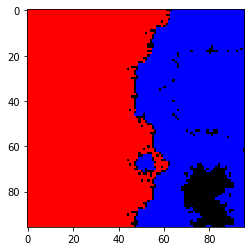

In [12]:
plt.imshow(train_inputs[1].astype('uint8'))
plt.show()

In [13]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (train_inputs, train_labels)).shuffle(1000000).batch(70)

test_ds = tf.data.Dataset.from_tensor_slices(
    (val_inputs, val_labels, val_true_weights)).shuffle(1000000).batch(3)
#for element in train_ds:
#    print(element)

In [17]:
class BasicBlock(tf.keras.layers.Layer):

    def __init__(self, filter_num, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size=(3, 3),
                                            strides=stride,
                                            padding="same")
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size=(3, 3),
                                            strides=1,
                                            padding="same")
        self.bn2 = tf.keras.layers.BatchNormalization()
        if stride != 1:
            self.downsample = tf.keras.Sequential()
            self.downsample.add(tf.keras.layers.Conv2D(filters=filter_num,
                                                       kernel_size=(1, 1),
                                                       strides=stride))
            self.downsample.add(tf.keras.layers.BatchNormalization())
        else:
            self.downsample = lambda x: x

    def call(self, inputs, training=None, **kwargs):
        residual = self.downsample(inputs)

        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = self.bn2(x, training=training)

        output = tf.nn.relu(tf.keras.layers.add([residual, x]))

        return output



def make_basic_block_layer(filter_num, blocks, stride=1):
    res_block = tf.keras.Sequential()
    res_block.add(BasicBlock(filter_num, stride=stride))

    for _ in range(1, blocks):
        res_block.add(BasicBlock(filter_num, stride=1))

    return res_block


class ResNet18(tf.keras.Model):
    def __init__(self):
        super(ResNet18, self).__init__()

        self.conv1 = tf.keras.layers.Conv2D(filters=64,
                                            kernel_size=(7, 7),
                                            strides=2,
                                            padding="same",
                                            use_bias=False)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=(3, 3),
                                               strides=2,
                                               padding="same")
        self.layer1 = make_basic_block_layer(filter_num=64, blocks=2)

        output_shape = (int(12), int(12))
        self.adaptivepool = tfa.layers.AdaptiveAveragePooling2D(output_shape)

    def call(self, inputs, training=None, mask=None):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.pool1(x)
        x = self.layer1(x, training=training)
        x = self.adaptivepool(x)
        output = tf.math.reduce_mean(x, axis=3)
        
        # here we need to insert the sampling part
        
        return output

In [18]:
model = ResNet18()

In [19]:
x = model(train_inputs[0:2])

In [20]:
x.shape

TensorShape([2, 12, 12])

In [21]:
x[1]

<tf.Tensor: shape=(12, 12), dtype=float32, numpy=
array([[0.17812225, 0.1679437 , 0.17145321, 0.16740134, 0.16961072,
        0.17783883, 0.2509198 , 0.36680955, 0.26270938, 0.23183264,
        0.22766383, 0.23955493],
       [0.18620709, 0.1891149 , 0.19189602, 0.18903935, 0.19540448,
        0.20945603, 0.31314462, 0.31903267, 0.27286512, 0.26295748,
        0.26392764, 0.25606704],
       [0.18656315, 0.19002295, 0.19096851, 0.18843687, 0.19848636,
        0.2625795 , 0.39172572, 0.30545175, 0.2450358 , 0.22532926,
        0.22387931, 0.2000069 ],
       [0.18993242, 0.18897396, 0.18714486, 0.18690069, 0.20094553,
        0.29204023, 0.32678884, 0.28592288, 0.20409125, 0.17984617,
        0.17578262, 0.16470394],
       [0.1893124 , 0.18907651, 0.18723068, 0.1859638 , 0.19744569,
        0.2818449 , 0.31007606, 0.27137884, 0.18332401, 0.17095137,
        0.17422155, 0.1597629 ],
       [0.18984273, 0.1874858 , 0.18590634, 0.18615924, 0.19715267,
        0.28680497, 0.29306132, 0.274

In [22]:
train_labels[1]

array([[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]], dtype=uint8)

In [23]:
dijkstra(x[1])

array([[0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.]], dtype=float32)

In [24]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam()

In [25]:
# custom accuracy function
class SameSolutionAccuracy(tf.keras.metrics.Metric):

    def __init__(self, name='same_solution_accuracy', **kwargs):
        super(SameSolutionAccuracy, self).__init__(name=name, **kwargs)
        self.same_solutions = self.add_weight(name='tp', initializer='zeros')
        self.counter = self.add_weight(name='counter', initializer='zeros')

    def update_state(self, y_true, y_pred, cost_matrix):
        y_true = tf.cast(y_true, tf.bool)
        # apply the combinatorial solver (dijkstra)
        y_pred = tf.cast(tf.map_fn(dijkstra, y_pred), tf.bool)
        # compute the cost of the shortest path
        y_true = tf.cast(tf.math.logical_not(y_true), tf.float32)
        y_pred = tf.cast(tf.math.logical_not(y_pred), tf.float32)
        
        #print(y_true)
        #print(y_pred)
        
        y_true = tf.reshape(y_true, [-1, 144])
        y_pred = tf.reshape(y_pred, [-1, 144])
        cost_matrix = tf.cast(cost_matrix, tf.float32)
        cost_matrix = tf.reshape(cost_matrix, [-1, 144])
        
        #print(y_true.shape)
        
        y_true_cost = tf.math.reduce_sum(cost_matrix * y_true, 1)
        y_pred_cost = tf.math.reduce_sum(cost_matrix * y_pred, 1)
        
        print(y_true_cost)
        print(y_pred_cost)
        
        # True if the cost is the same
        equal_values = tf.cast(tf.math.less_equal(y_pred_cost, y_true_cost), tf.float32)
        print(equal_values)
        sum_correct_in_batch = tf.math.reduce_sum(equal_values)
        print(sum_correct_in_batch)
        print(y_true.shape[0])

        self.same_solutions.assign_add(sum_correct_in_batch)
        self.counter.assign_add(y_true.shape[0])
        
        
        print("---")

    def result(self):
        return self.same_solutions/self.counter

In [833]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')
train_samesol = SameSolutionAccuracy()

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_accuracy')
test_samesol = SameSolutionAccuracy()

In [834]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)
    #train_samesol(labels,predictions)

In [835]:
#@tf.function
def test_step(images, labels, cost_matrix):
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)
    #print(labels)
    test_samesol(labels, predictions, cost_matrix)

In [765]:
for epoch in range(10):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}, SameSol: {}'
    print(template.format(epoch + 1,
                        train_loss.result(),
                        train_accuracy.result() * 100,
                        test_loss.result(),
                        test_accuracy.result() * 100,
                        test_samesol.result()))    

Epoch 1, Loss: 0.2821696400642395, Accuracy: 90.35498809814453, Test Loss: 0.0, Test Accuracy: 0.0, SameSol: nan
Epoch 2, Loss: 0.23414956033229828, Accuracy: 91.49168395996094, Test Loss: 0.0, Test Accuracy: 0.0, SameSol: nan
Epoch 3, Loss: 0.21846000850200653, Accuracy: 91.8009033203125, Test Loss: 0.0, Test Accuracy: 0.0, SameSol: nan
Epoch 4, Loss: 0.20886795222759247, Accuracy: 92.05645751953125, Test Loss: 0.0, Test Accuracy: 0.0, SameSol: nan
Epoch 5, Loss: 0.20310209691524506, Accuracy: 92.18443298339844, Test Loss: 0.0, Test Accuracy: 0.0, SameSol: nan
Epoch 6, Loss: 0.19837835431098938, Accuracy: 92.34528350830078, Test Loss: 0.0, Test Accuracy: 0.0, SameSol: nan
Epoch 7, Loss: 0.1952897608280182, Accuracy: 92.427978515625, Test Loss: 0.0, Test Accuracy: 0.0, SameSol: nan
Epoch 8, Loss: 0.19228394329547882, Accuracy: 92.49514770507812, Test Loss: 0.0, Test Accuracy: 0.0, SameSol: nan
Epoch 9, Loss: 0.18993151187896729, Accuracy: 92.57743072509766, Test Loss: 0.0, Test Accurac

In [831]:
test_loss.reset_states()
test_accuracy.reset_states()
test_samesol.reset_states()

for test_images, test_labels, cost_matrix in test_ds:
    test_step(test_images, test_labels, cost_matrix)
    
template = 'Epoch {}, Test Loss: {}, Test Accuracy: {}, SameSol: {}'
print(template.format(epoch + 1,
                   test_loss.result(),
                   test_accuracy.result() * 100,
                   test_samesol.result()))

tf.Tensor([39.208008 39.404297 39.899414], shape=(3,), dtype=float32)
tf.Tensor([39.609375 43.003906 39.899414], shape=(3,), dtype=float32)
---
tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor([17.201172 24.59961  29.605469], shape=(3,), dtype=float32)
tf.Tensor([17.201172 25.90039  31.607422], shape=(3,), dtype=float32)
---
tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor([13.599609 20.200195 33.40039 ], shape=(3,), dtype=float32)
tf.Tensor([14.399414 20.200195 33.401367], shape=(3,), dtype=float32)
---
tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor([29.398438 44.411133 29.601562], shape=(3,), dtype=float32)
tf.Tensor([29.399414 46.509766 31.201172], shape=(3,), dtype=float32)
---
tf.Tensor([0. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor([18.402344 38.808594 18.40039 ], shape=(3,), dtype=float32)
tf.Tensor([18.402344 39.6084   19.200195], shape=(3,), dtype=float32)
---
tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor([33.606445 29.5      42.3

KeyboardInterrupt: 

In [ ]:
val_labels[1]

In [ ]:
x = model(val_inputs[0:2])
x[1]
#1-dijkstra(x[1]).shortest_path